In [2]:
import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

1.13.1
Using a GPU


In [3]:
#!python setup.py install --user
# Copyright (C) PROWLER.io 2018
#
# Licensed under the Apache License, Version 2.0

# Script to reproduce Figure 3 from Sun et al.
import numpy as np
import pandas as pd
#import seaborn as sns
from sklearn.model_selection import train_test_split
import gpflow as gf

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')

In [4]:
block0 = pd.read_csv('../OriginalCode/subFeaturesAll.csv')
data = block0[['AGE','EDU','GENDER','DX']]
mask = np.isfinite(data['AGE'])
data = data[mask]
#data.DX.unique()
train, test = train_test_split(data, test_size=0.2, stratify=data.DX)
maskT = data.index.isin(train.index)
len(maskT)

K1 = pd.read_csv('../OriginalCode/thickPH0thinKernelPD.tsv', header=None, sep='\t').values
K1 = K1[mask,:]
K1 = K1[:,mask]
K1Tr = K1[maskT,:]
K1Tr = K1Tr[:,maskT]
K2 = pd.read_csv('../OriginalCode/thickPH1thinKernelPD.tsv', header=None, sep='\t').values
K2 = K2[mask,:]
K2 = K2[:,mask]
K2Tr = K2[maskT,:]
K2Tr = K2Tr[:,maskT]
n = len(K2Tr)
#K2Tr = K2Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K2Tr)
#K1Tr = K1Tr + 1e4 * np.eye(n)
np.linalg.cholesky(K1Tr)

array([[ 3.00434200e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.77391368e+01,  3.51964690e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.96012993e+01,  4.41392573e+01,  1.96437016e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.51003100e+01,  7.05210168e+00, -1.87449845e+00, ...,
         1.10414505e-01,  0.00000000e+00,  0.00000000e+00],
       [ 3.67068138e+01,  5.37029186e+00, -2.54771992e+00, ...,
        -5.63745080e-03,  1.02960858e-01,  0.00000000e+00],
       [ 3.71795670e+01,  7.88086674e+00, -3.29412301e+00, ...,
         3.55345043e-03,  1.76260937e-03,  5.57018117e-02]])

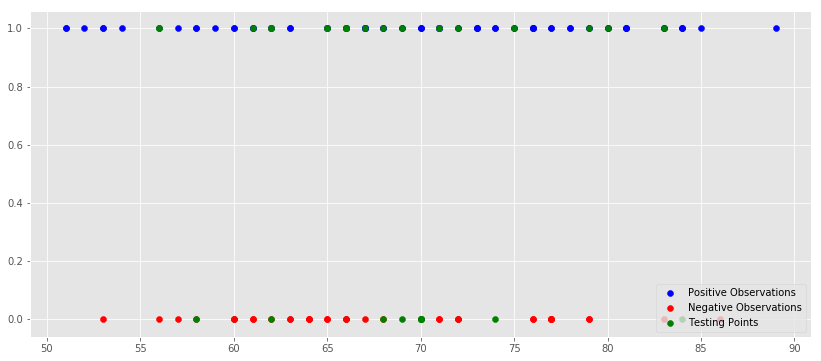

In [212]:
# Number of training points
n = len(train)
X0 = train[['AGE']].astype(float).values

# Number of testing points
m = len(test)
X = test[['AGE']].astype(float).values

n = len(train)
Y0 = train[['DX']].values
Y = test[['DX']].values
# Separate data into positive and negative classes
Y[Y == 'MCI'] = 1
Y[Y == 'NC'] = 0
Y0[Y0 == 'MCI'] = 1
Y0[Y0 == 'NC'] = 0
Y = Y.astype('float64') 
Y0 = Y0.astype('float64') 

fig, ax = plt.subplots(figsize=(14, 6));
ax.scatter(X0, np.ma.masked_where(Y0 == 0, Y0), color='b', label='Positive Observations');
ax.scatter(X0, np.ma.masked_where(Y0 == 1, Y0), color='r', label='Negative Observations');
ax.scatter(X, Y, color='g', label='Testing Points');
ax.legend(loc='lower right');

In [149]:
len(X0)

124

In [150]:
m = gf.models.VGP(X0, Y0,
                      kern=gf.kernels.RBF(1),
                      likelihood=gf.likelihoods.Bernoulli())

opt = gf.train.ScipyOptimizer()
opt.minimize(m, maxiter=50) # in practice, the optimisation needs around 250 iterations to converge

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 80.589275
  Number of iterations: 50
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 80.589275
  Number of iterations: 50
  Number of functions evaluations: 53


In [151]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/variance,Parameter,None,+ve,True,(),True,0.1545197350829945
VGP/kern/lengthscales,Parameter,None,+ve,True,(),True,14.643438886842135
VGP/q_mu,Parameter,None,(none),True,"(124, 1)",True,"[[1.2930792056906013], [0.3622175847627762], [..."
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 124, 124)",True,"[[[0.39918884561020823, 0.0, 0.0, 0.0, 0.0, 0...."


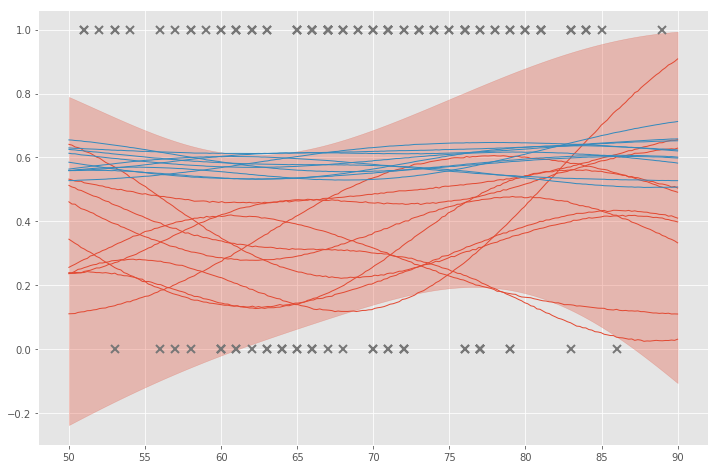

In [152]:
x_grid = np.linspace(50, 90, 200).reshape(-1, 1)
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)
plt.fill_between(x_grid.flatten(),
                 (mu + 2 * np.sqrt(var)).flatten(),
                 (mu - 2 * np.sqrt(var)).flatten(),
                 alpha=0.3, color='C0')
    
# plot samples
samples = m.predict_f_samples(x_grid, 10).squeeze().T
plt.plot(x_grid, samples, 'C0', lw=1)
    
# plot p-samples
p = np.exp(samples) / (1. + np.exp(samples))
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X0, Y0, 'C3x', ms=8, mew=2)
#plt.ylim((-3,3))

In [174]:
K1 = pd.read_csv('../OriginalCode/thickPH0thickKernelPD.tsv', header=None, sep='\t').values
K2 = pd.read_csv('../OriginalCode/thickPH1thickKernelPD.tsv', header=None, sep='\t').values
K3 = pd.read_csv('../OriginalCode/thickPH0thinKernelPD.tsv', header=None, sep='\t').values
K4 = pd.read_csv('../OriginalCode/thickPH1thinKernelPD.tsv', header=None, sep='\t').values

K1T = K1[(train.index.values.reshape((n, 1)), train.index.values.reshape((1, n)))]
K2T = K2[(train.index.values.reshape((n, 1)), train.index.values.reshape((1, n)))]
K3T = K3[(train.index.values.reshape((n, 1)), train.index.values.reshape((1, n)))]
K4T = K4[(train.index.values.reshape((n, 1)), train.index.values.reshape((1, n)))]

z = np.arange(len(K1T))
tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
tile_a = tf.expand_dims(tile_a, 2) 
tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
tile_b = tf.expand_dims(tile_b, 2)
K1TF = tf.gather_nd(K1T, tf.concat([tile_a, tile_b], axis=2))
K1TF.shape

TensorShape([Dimension(124), Dimension(124)])

In [177]:
with tf.Session() as sess:  print(K1TF.eval()) 

[[ 758.94884285  645.17955669  649.55180888 ...  662.47579819
   786.95718779  571.93968526]
 [ 645.17955669  605.00794997  564.50188596 ...  579.06443781
   776.55756996  475.4543615 ]
 [ 649.55180888  564.50188596  559.70765675 ...  570.95044897
   696.53212456  487.24079265]
 ...
 [ 662.47579819  579.06443781  570.95044897 ...  583.17312984
   716.77302516  496.45036622]
 [ 786.95718779  776.55756996  696.53212456 ...  716.77302516
  1033.17158673  573.95534475]
 [ 571.93968526  475.4543615   487.24079265 ...  496.45036622
   573.95534475  434.81794685]]


In [178]:
K1T

array([[ 758.94884285,  645.17955669,  649.55180888, ...,  662.47579819,
         786.95718779,  571.93968526],
       [ 645.17955669,  605.00794997,  564.50188596, ...,  579.06443781,
         776.55756996,  475.4543615 ],
       [ 649.55180888,  564.50188596,  559.70765675, ...,  570.95044897,
         696.53212456,  487.24079265],
       ...,
       [ 662.47579819,  579.06443781,  570.95044897, ...,  583.17312984,
         716.77302516,  496.45036622],
       [ 786.95718779,  776.55756996,  696.53212456, ...,  716.77302516,
        1033.17158673,  573.95534475],
       [ 571.93968526,  475.4543615 ,  487.24079265, ...,  496.45036622,
         573.95534475,  434.81794685]])

In [179]:
class persistenceScaleSpace(gf.kernels.Kernel):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])
        self.variance = gf.Param(1.0, transform=gf.transforms.positive)

    @gf.params_as_tensors
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.variance * K1TF # this returns a 2D tensor

    @gf.params_as_tensors
    def Kdiag(self, X):
        return self.variance * tf.linalg.tensor_diag_part(K1TF)           # this returns a 1D tensor
    
k_test = persistenceScaleSpace()
k_test

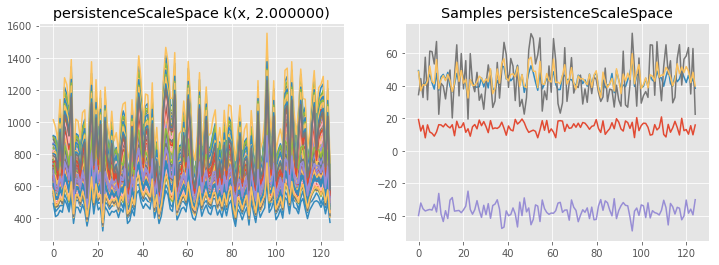

In [181]:
def plotkernelsample(k, ax, xmin=0, xmax=124):
    xx = np.linspace(xmin, xmax, 124)[:,None]
    K = K1T
    ax.plot(xx, np.random.multivariate_normal(np.zeros(124), K, 5).T)
    ax.set_title('Samples ' + k.__class__.__name__)

def plotkernelfunction(k, ax, xmin=0, xmax=124, other=0):
    xx = np.linspace(xmin, xmax, 124)[:,None]
    ax.plot(xx, K1T + other)
    ax.set_title(k.__class__.__name__ + ' k(x, %f)'%other)

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
plotkernelfunction(k_test, axes[0], other=2.)
plotkernelsample(k_test, axes[1])

In [182]:
k1 = persistenceScaleSpace()
k2 = gf.kernels.Constant(1000)
k = k1 + k2
k

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.233020
  Number of iterations: 10
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.233020
  Number of iterations: 10
  Number of functions evaluations: 13


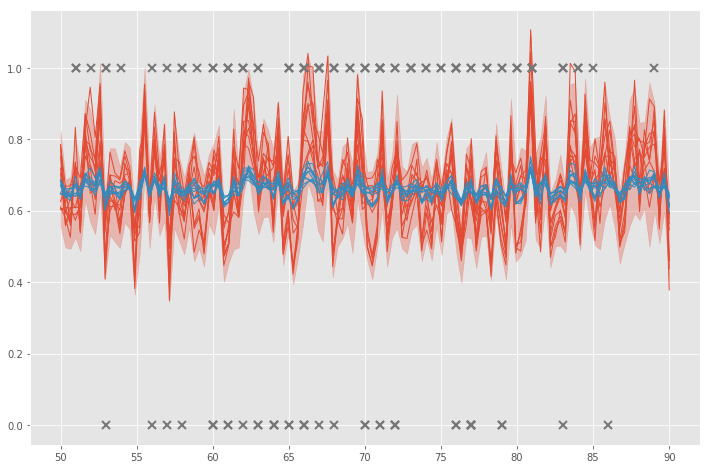

In [215]:
m = gf.models.GPR(X0, Y0, kern=k1)
opt = gf.train.ScipyOptimizer()
opt.minimize(m)

x_grid = np.linspace(50, 90, 124).reshape(-1, 1)
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)
plt.fill_between(x_grid.flatten(),
                 (mu + 2 * np.sqrt(var)).flatten(),
                 (mu - 2 * np.sqrt(var)).flatten(),
                 alpha=0.3, color='C0')
    
# plot samples
samples = m.predict_f_samples(x_grid, 10).squeeze().T
plt.plot(x_grid, samples, 'C0', lw=1)

# plot p-samples
p = np.exp(samples) / (1. + np.exp(samples))
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X0, Y0, 'C3x', ms=8, mew=2)
#plt.ylim((-3,3))

In [214]:
# Change X axis into label order
train

,AGE,EDU,GENDER,DX
49,77.0,16.0,M,NC
93,79.0,18.0,M,NC
74,68.0,16.0,F,MCI
127,63.0,16.0,F,MCI
67,64.0,16.0,F,NC
...,...,...,...,...
131,68.0,18.0,M,MCI
114,80.0,14.0,M,MCI
158,60.0,12.0,M,MCI
28,85.0,14.0,F,MCI


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.233020
  Number of iterations: 10
  Number of functions evaluations: 13


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 88.233020
  Number of iterations: 10
  Number of functions evaluations: 13


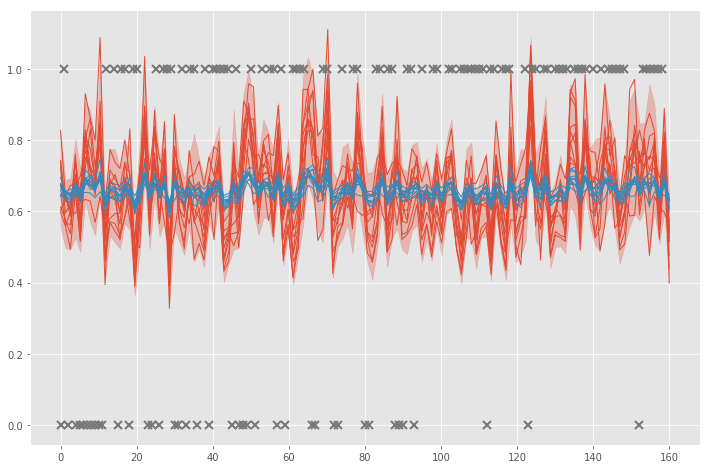

In [207]:
m = gf.models.GPR(X0i, Y0, kern=k1)
opt = gf.train.ScipyOptimizer()
opt.minimize(m)

x_grid = np.linspace(0, 160, 124).reshape(-1, 1)
plt.figure(figsize=(12, 8))

# bubble fill the predictions
mu, var = m.predict_f(x_grid)
plt.fill_between(x_grid.flatten(),
                 (mu + 2 * np.sqrt(var)).flatten(),
                 (mu - 2 * np.sqrt(var)).flatten(),
                 alpha=0.3, color='C0')
    
# plot samples
samples = m.predict_f_samples(x_grid, 10).squeeze().T
plt.plot(x_grid, samples, 'C0', lw=1)

# plot p-samples
p = np.exp(samples) / (1. + np.exp(samples))
plt.plot(x_grid, p, 'C1', lw=1)

# plot data
plt.plot(X0i, Y0, 'C3x', ms=8, mew=2)